In [1]:
import numpy as np
import pandas as pd
from plotnine import *
from sklearn.datasets import make_blobs
import patchworklib as pw

def get_w(m, n_comps=3):
  eigenvalues, eigenvectors = np.linalg.eigh(m)

  # Step 4: Sort eigenvalues and eigenvectors in descending order
  sorted_indices = np.argsort(eigenvalues)[::-1]
  eigenvalues = eigenvalues[sorted_indices]
  eigenvectors = eigenvectors[:, sorted_indices]
  return eigenvectors[:, :n_comps]

<Figure size 100x100 with 0 Axes>

In [2]:
def gen_data(sample_size, number_of_features, rho=0.5, var=2):

    # Create the AR(1) covariance matrix
    indices = np.arange(number_of_features)
    cor_matrix = rho ** np.abs(np.subtract.outer(indices, indices))
    std_mat = np.diag(np.ones(number_of_features)) * np.sqrt(var)
    cov_matrix = std_mat @ cor_matrix @ std_mat

    # Generate MVN data
    return np.random.multivariate_normal(np.zeros(number_of_features), cov_matrix, size=sample_size)

X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)

def gen_data2(sample_size, number_of_features, number_of_clusters, var=2):
    _data, _ = make_blobs(n_samples=sample_size, centers=number_of_clusters, n_features=number_of_features, cluster_std=np.sqrt(var))
    return _data    

In [ ]:
n_sim = 10
n = 50
N = 1_000
n_samples = n + N
n_features = 500
n_test = 10_000
n_comps = int(n * 0.9)
_lambda = 1
rho = 0.8

print(f"n={n}, N={N}, n_samples={n_samples}, n_features={n_features}, n_comps={n_comps}, rho={rho}")

g_test = gen_data(n_test, n_features, rho=0, var=5)
e_test = gen_data(n_test, n_features, rho=rho, var=5)
X_test = g_test + e_test
pred_test = g_test
W_test = get_w((X_test.T @ X_test) / n_test, n_comps=n_comps)

# E = [gen_data2(n_samples, n_features, 10, var=2) for _ in range(n_sim)]
G = [gen_data(n_samples, n_features, rho=0, var=5) for _ in range(n_sim)]
E = [gen_data(n_samples, n_features, rho=rho, var=5) for _ in range(n_sim)]

errors_ppi = []
errors_pred = []
errors_lab = []
w_errors_ppi = []
w_errors_pred = []
w_errors_lab = []
covs_lab = []
covs_pred_lab = []
for i in range(n_sim):
  if i % 10 == 0:
    print(f"i={i}")
  # e = gen_data(n_samples, n_features, rho=rho, var=5)
  e = E[i]
  g = G[i]
  X_full = g + e
  preds_full = g
  X_lab = X_full[:n]
  X_pred_lab = preds_full[:n]
  X_unlab = preds_full[n:]
   
  X_lab = (X_lab - X_lab.mean(axis=0)) / X_lab.std(axis=0)
  X_pred_lab = (X_pred_lab - X_pred_lab.mean(axis=0)) / X_pred_lab.std(axis=0)
  X_unlab = (X_unlab - X_unlab.mean(axis=0)) / X_unlab.std(axis=0)
  preds_full = (preds_full - preds_full.mean(axis=0)) / preds_full.std(axis=0)

  Sigma_lab = (X_lab.T @ X_lab) / n
  Sigma_pred = (preds_full.T @ preds_full) / n_samples
  Omega = ((X_lab.T @ X_lab) / n) - ((X_pred_lab.T @ X_pred_lab) / n) + ((X_unlab.T @ X_unlab) / N)
  # Omega = ((X_lab.T @ X_lab) / n) + _lambda * (((X_unlab.T @ X_unlab) / N) - ((X_pred_lab.T @ X_pred_lab) / n))

  W_lab = get_w(Sigma_lab, n_comps=n_comps)
  W_pred = get_w(Sigma_pred, n_comps=n_comps)
  W_ppi = get_w(Omega, n_comps=n_comps)
  # Z_lab = X_test @ W_lab
  # Z_pred = X_test @ W_pred
  # Z_ppi = X_test @ W_ppi
  Z_lab = pred_test @ W_lab
  Z_pred = pred_test @ W_pred
  Z_ppi = pred_test @ W_ppi

  Xhat_lab = Z_lab @ W_lab.T
  Xhat_pred = Z_pred @ W_pred.T
  Xhat_ppi = Z_ppi @ W_ppi.T
  error_lab = np.linalg.norm(X_test - Xhat_lab)
  error_pred = np.linalg.norm(X_test - Xhat_pred)
  error_ppi = np.linalg.norm(X_test - Xhat_ppi)
  errors_lab.append(error_lab)
  errors_pred.append(error_pred)
  errors_ppi.append(error_ppi)
  
  W_error_lab = np.linalg.norm(W_lab - W_test)
  W_error_pred = np.linalg.norm(W_pred - W_test)
  W_error_ppi = np.linalg.norm(W_ppi - W_test)
  w_errors_lab.append(W_error_lab)
  w_errors_pred.append(W_error_pred)
  w_errors_ppi.append(W_error_ppi)

d = pd.DataFrame(
    {
        "lab": errors_lab,
        "pred": errors_pred,
        "ppi": errors_ppi,
    }
)
d.agg({"lab": ["mean", "std"], "pred": ["mean", "std"], "ppi": ["mean", "std"]})

n=50, N=1000, n_samples=1050, n_features=500, n_comps=45, rho=0.8
i=0


,lab,pred,ppi
mean,6910.225349,6909.333342,6910.391248
std,1.031241,0.438208,0.943927


0.71 0.65 0.76


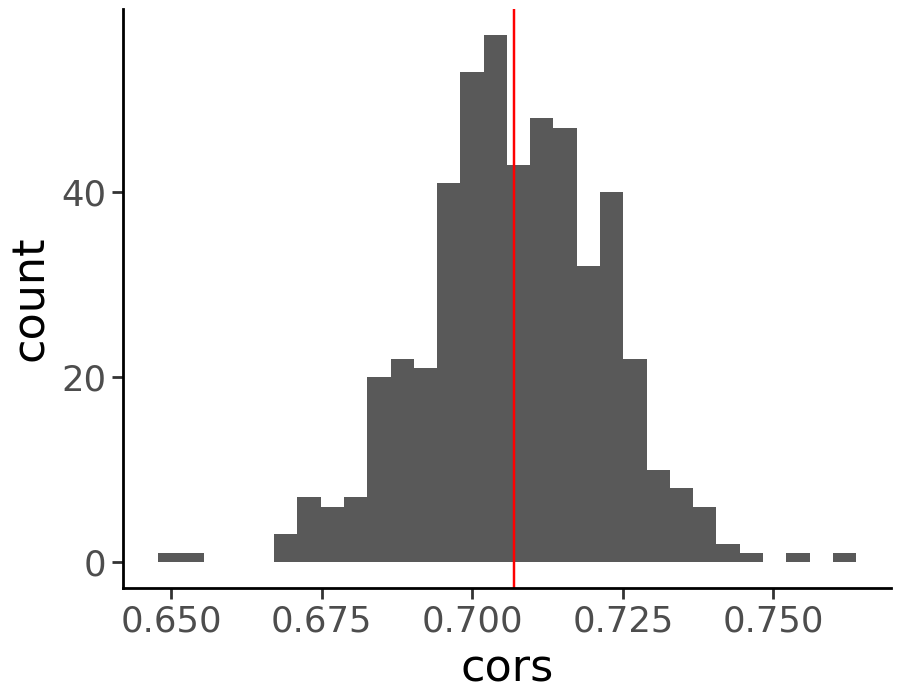

In [55]:
cors = []
for i in range(X_full.shape[1]):
  cors.append(np.corrcoef(X_full[:, i], preds_full[:, i])[0, 1])

cors = np.array(cors)
print(cors.mean().round(2), cors.min().round(2), cors.max().round(2))
ggplot(pd.DataFrame({"cors": cors}), aes(x="cors")) + \
  geom_histogram(bins=30) + \
  geom_vline(xintercept=cors.mean(), color="red") + \
  theme_classic(base_size=16) + \
  theme(plot_background=element_rect(fill='white'), figure_size=(4.5,3.5))

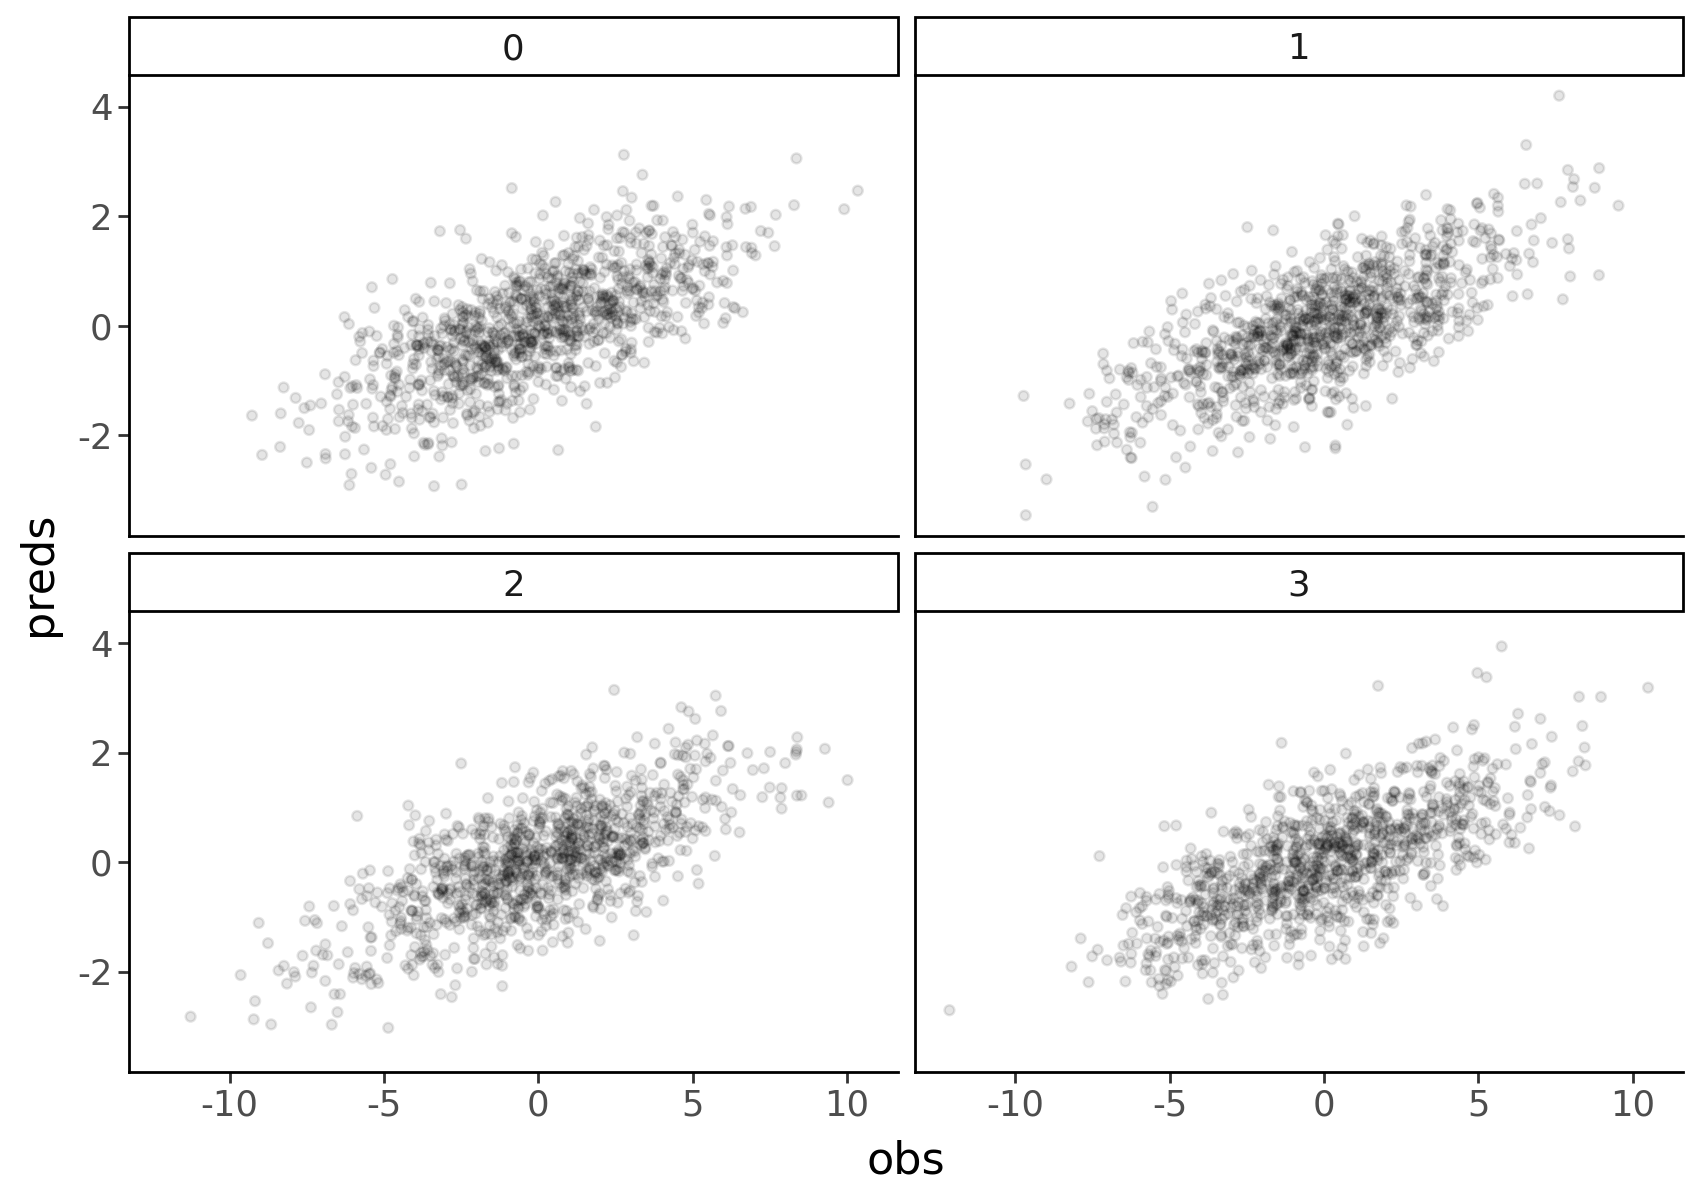

In [58]:
mydf = pd.DataFrame(X_full).melt().rename(columns={"value": "obs"}).join(
    pd.DataFrame(preds_full).melt().rename(columns={"value": "preds"}),
    rsuffix="_pred"
)
ggplot(mydf.query("variable in [0,1,2,3]"), aes(x="obs", y="preds")) + \
    geom_point(alpha=0.1) + \
    facet_wrap("~variable") + \
    theme_classic(base_size=16) + \
    theme(plot_background=element_rect(fill='white'), figure_size=(8.5,6))

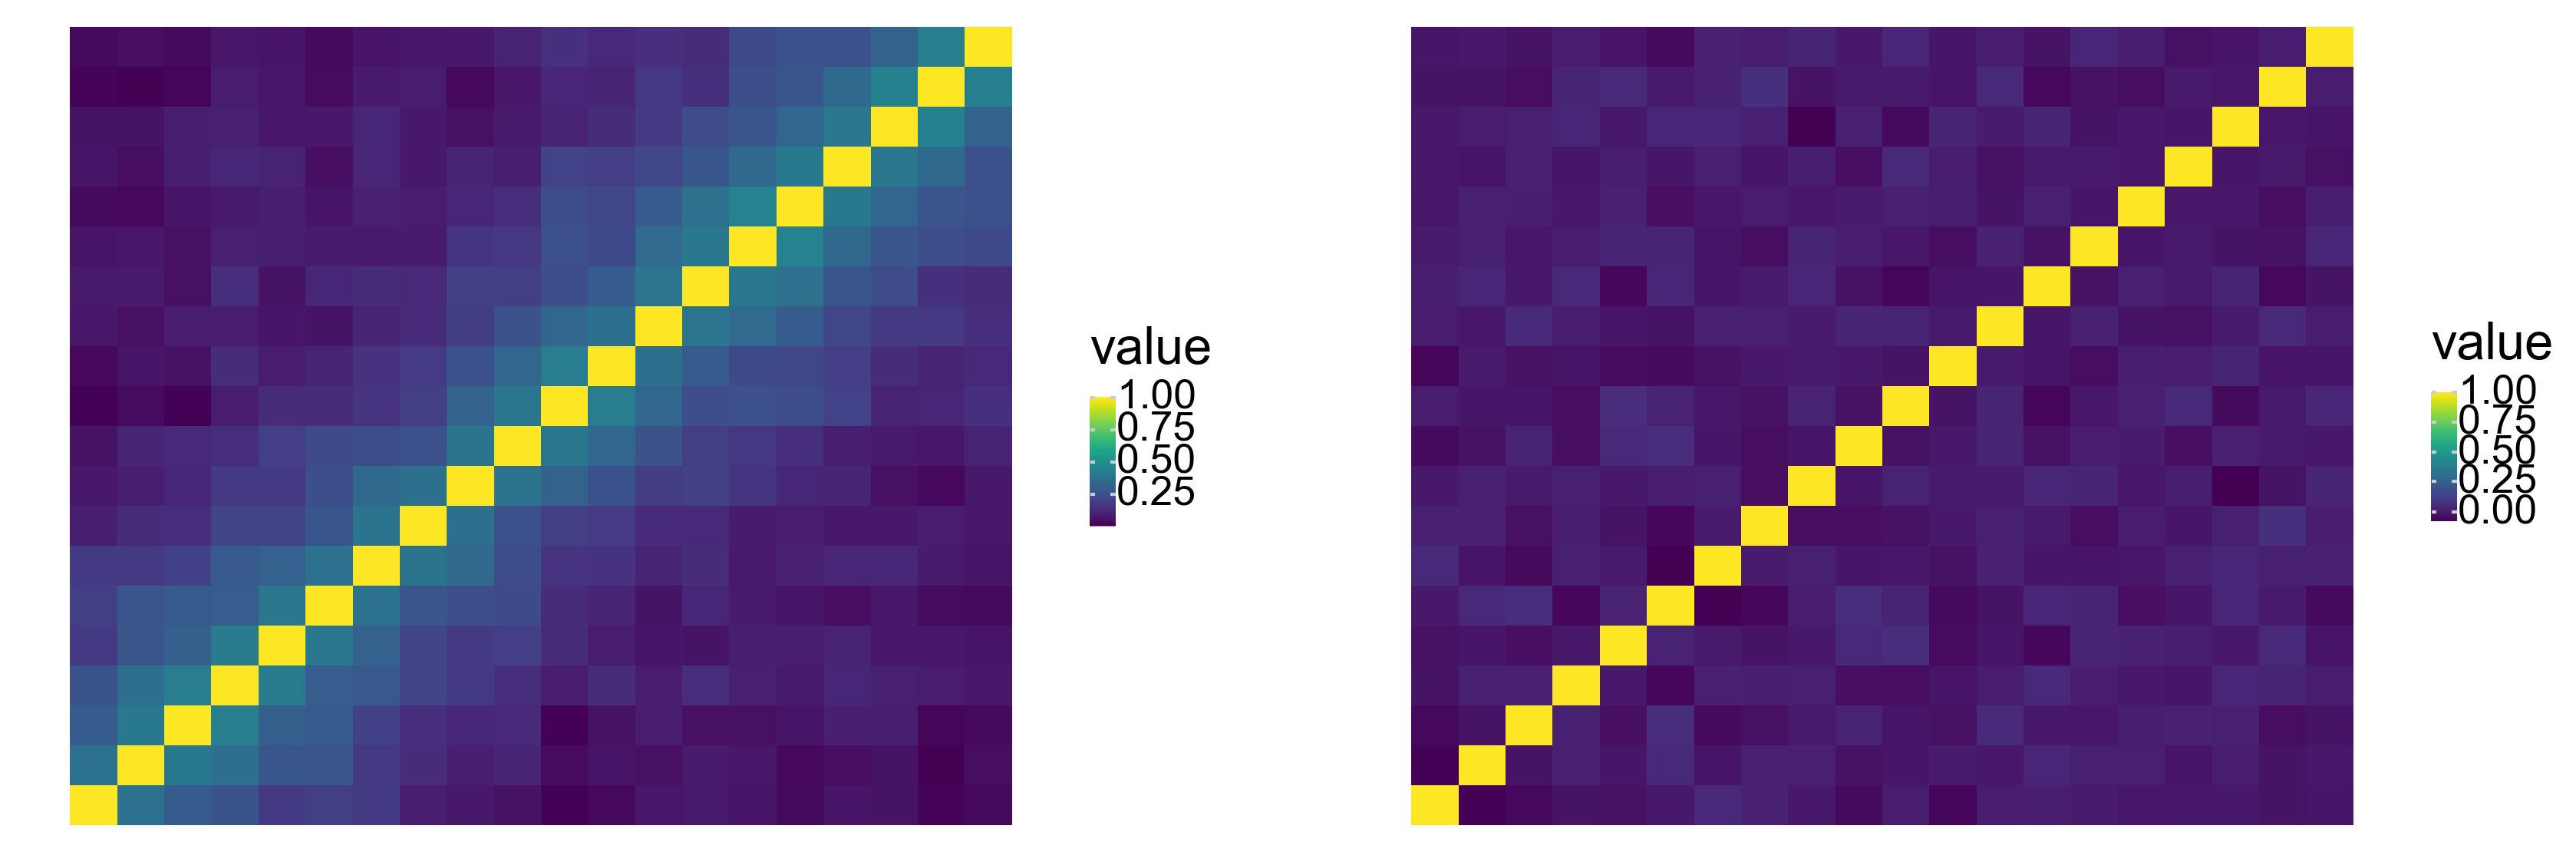

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [59]:
cor_mat_obs = np.corrcoef(X_full.T)
cor_mat_preds = np.corrcoef(preds_full.T)
# p1 = ggplot(pd.DataFrame(cor_mat_obs)) + \
#     geom_tile(aes(x="X1", y="X2", fill="value")) + \
#     theme_classic(base_size=16) + \
#     theme(plot_background=element_rect(fill='white'), figure_size=(4.5,3.5))

p1 = ggplot(
    pd.DataFrame(cor_mat_obs[:20, :20]).reset_index().melt(id_vars="index").rename(columns={"index": "X1", "variable": "X2"}),
    aes(x="X1", y="X2", fill="value")
) + \
    geom_tile() + \
    theme_void(base_size=16) + \
    theme(plot_background=element_rect(fill='white'), figure_size=(4.5,3.5))
p2 = ggplot(
    pd.DataFrame(cor_mat_preds[:20, :20]).reset_index().melt(id_vars="index").rename(columns={"index": "X1", "variable": "X2"}),
    aes(x="X1", y="X2", fill="value")
) + \
    geom_tile() + \
    theme_void(base_size=16) + \
    theme(plot_background=element_rect(fill='white'), figure_size=(4.5,3.5))
    
pw.load_ggplot(p1) + pw.load_ggplot(p2)

           lab      pred       ppi
mean  9.481658  9.482205  9.495026
std   0.047596  0.023466  0.064260


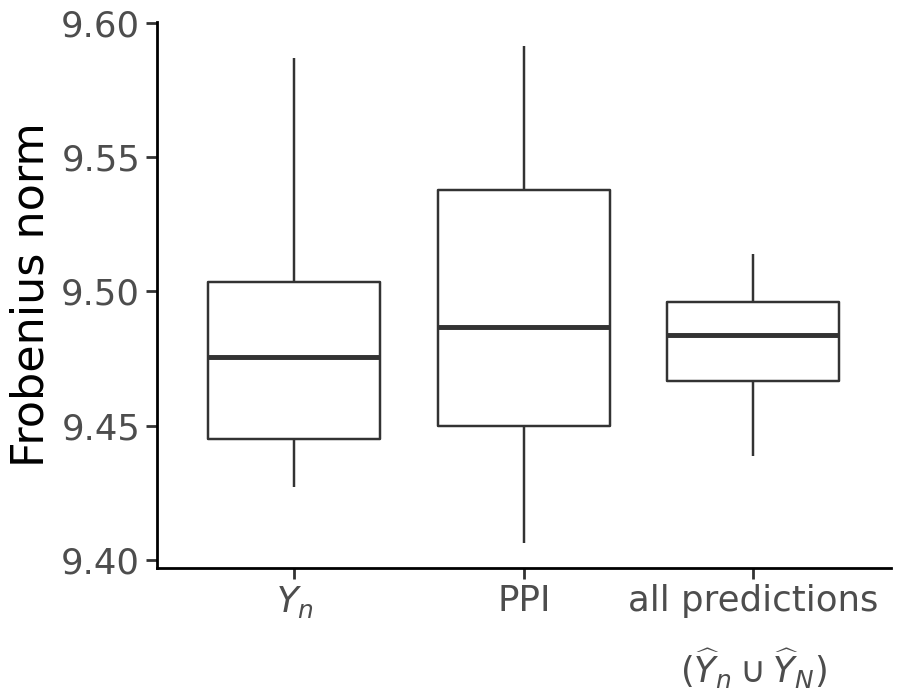

In [ ]:
dw = pd.DataFrame(
    {
        "lab": w_errors_lab,
        "pred": w_errors_pred,
        "ppi": w_errors_ppi,
    }
)
print(dw.agg({"lab": ["mean", "std"], "pred": ["mean", "std"], "ppi": ["mean", "std"]}))
ggplot(dw.melt(), aes(x="variable", y="value")) + \
    geom_boxplot() + \
    theme_classic(base_size=16) + \
    theme(plot_background=element_rect(fill='white'), figure_size=(4.5,3.5)) + \
    labs(y="Frobenius norm", x="", titble="Error on W") + \
    scale_x_discrete(labels=["$Y_n$", "PPI", "all predictions\n\n$(\widehat{Y}_n \cup \widehat{Y}_N)$"])

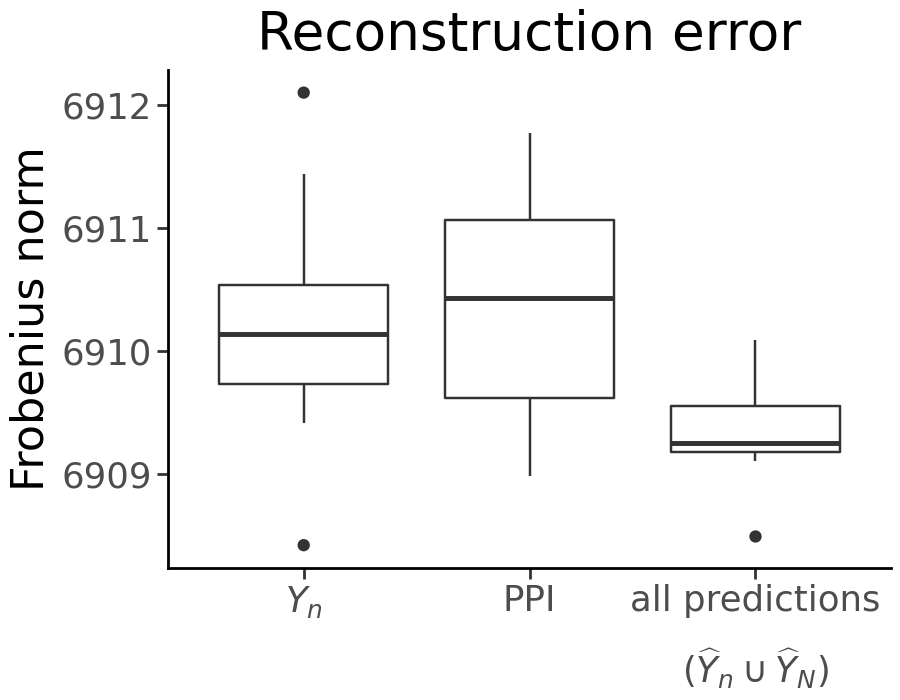

In [62]:
ggplot(d.melt(), aes(x="variable", y="value")) + \
    geom_boxplot() + \
    theme_classic(base_size=16) + \
    theme(plot_background=element_rect(fill='white'), figure_size=(4.5,3.5)) + \
    labs(y="Frobenius norm", x="", title="Reconstruction error") + \
    scale_x_discrete(labels=["$Y_n$", "PPI", "all predictions\n\n$(\widehat{Y}_n \cup \widehat{Y}_N)$"])

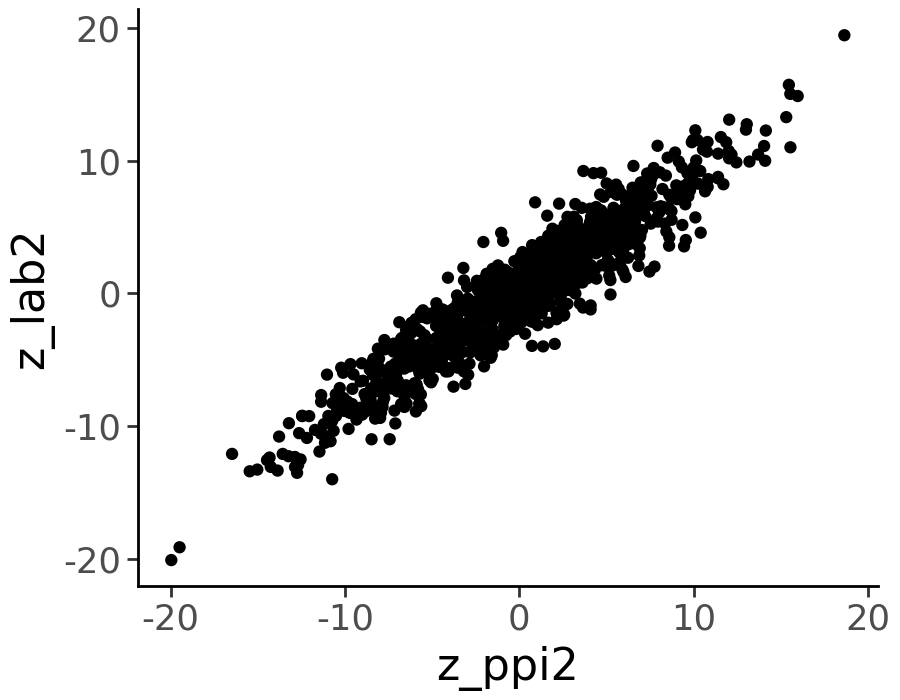

In [41]:
Z_test = X_test @ W_test
zs = pd.DataFrame(
    {
        "z_lab1": Z_lab[:, 0],
        "z_lab2": Z_lab[:, 1],
        "z_pred1": Z_pred[:, 0],
        "z_pred2": Z_pred[:, 1],
        "z_ppi1": Z_ppi[:, 0],
        "z_ppi2": Z_ppi[:, 1],
        "z_test1": Z_test[:, 0],
        "z_test2": Z_test[:, 1]
    }
)

ggplot(zs, aes(x="z_ppi2", y="z_lab2")) + \
    geom_point() + \
    theme_classic(base_size=16) + \
    theme(plot_background=element_rect(fill='white'), figure_size=(4.5,3.5)) 

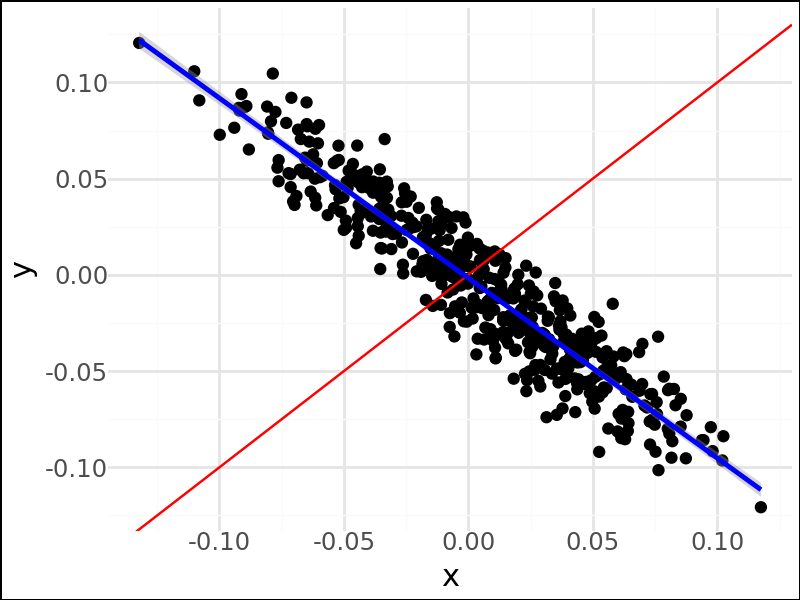

In [42]:
ggplot(
    pd.DataFrame(np.c_[W_lab[:, 0], -W_ppi[:, 0]], columns=["x", "y"]), aes(x="x", y="y")
) + \
    geom_point() + \
    geom_abline(slope=1, intercept=0, color="red") + \
    theme_minimal() + \
    theme(plot_background=element_rect(fill='white'), figure_size=(4,3)) + \
    geom_smooth(method="lm", color="blue")

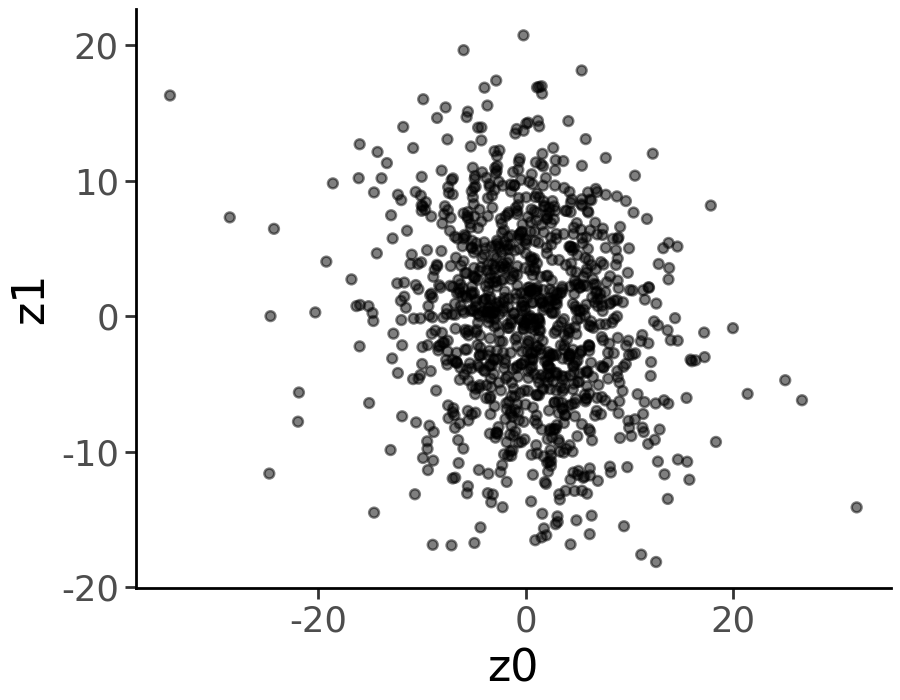

In [ ]:
z_test_pred = preds_full @ W_test
z_test_obs = X_full @ W_test
z_ppi_pred = preds_full @ W_ppi
z_ppi_obs = X_full @ W_ppi
z_lab_pred = preds_full @ W_lab
z_lab_obs = X_full @ W_lab
ggplot(pd.DataFrame(np.c_[z_ppi_pred[:, 0], z_test_pred[:, 0]], columns=["z0", "z1"]), aes(x="z0", y="z1")) + \
    geom_point(alpha=0.5) + \
    theme_classic(base_size=16) + \
    theme(plot_background=element_rect(fill='white'), figure_size=(4.5,3.5))

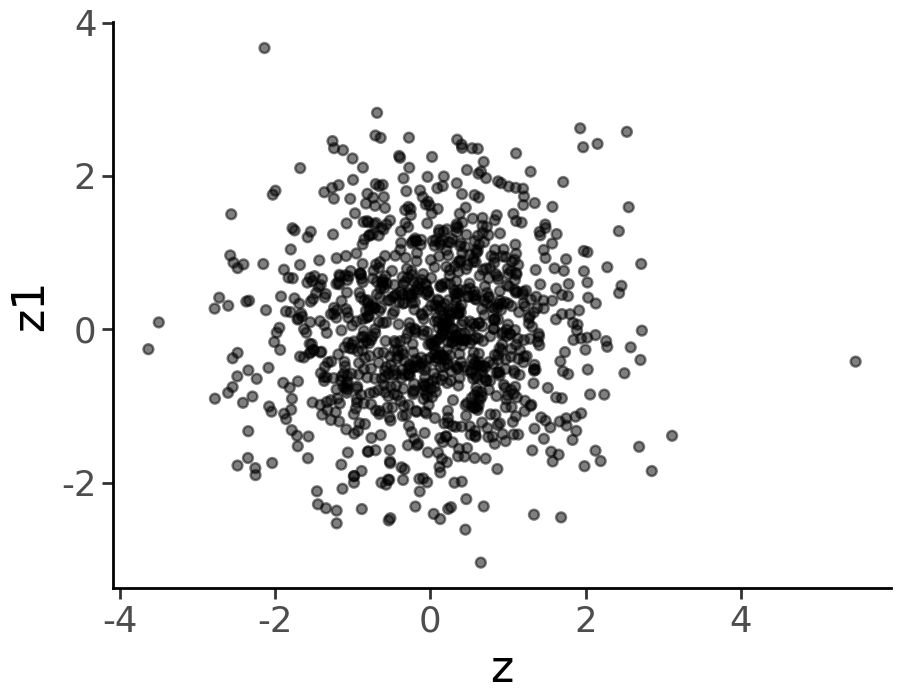

In [ ]:

ggplot(pd.DataFrame(z_ppi[:, :2], columns=["z0", "z1"]), aes(x="z0", y="z1")) + \
    geom_point(alpha=0.5) + \
    theme_classic(base_size=16) + \
    theme(plot_background=element_rect(fill='white'), figure_size=(4.5,3.5)) + \
    labs(x="z")

In [26]:
a = ((X_lab.T @ X_lab) / n)
b = ((X_pred_lab.T @ X_pred_lab) / n)
ggplot(
    pd.DataFrame(np.c_[a[:, 1], b[:, 1]], columns=["x", "y"]), aes(x="x", y="y")
) + geom_point() + geom_smooth()
for i in range(X_lab.shape[1]):
  print(np.corrcoef(X_lab[:, i], X_pred_lab[:, i])[0, 1])

0.5116009318971246
0.2838242606150901
0.6815924920396196
0.42978052056136573
0.34953343117375935
0.506590053586421
0.22377937818203872
0.7456727263950668
-0.21729259925855593
0.4655887936454798
0.15273138277293075
0.4913636908153522
0.1437809866852554
0.402654735665936
0.2780966828531797
0.4293196033911256
-0.18493966656486924
0.7761627888378466
-0.31633878698402346
0.7174772937912931
-0.07743286434324666
0.7857081262181165
-0.1392310222947191
-0.10206788085770231
0.34346652829744523
0.540596460281831
0.023907748976689236
0.7427190007848103
0.12545600834291898
0.47826262345746434
-0.2360515809963546
0.6472245563660282
0.17124711323792693
0.39558712578792915
0.3649498229530429
0.0657866720290227
0.42312217691636644
0.5798941786159616
0.5141040853999939
0.6301283545569344
0.3960488764938289
-0.3362967337139464
0.8023686560701164
0.2044317007343129
0.626893562819672
-0.11502084080740903
0.7396009749177559
0.08066501368786314
0.6507035602147464
0.38743740842142527
0.08955855303996113
0.765

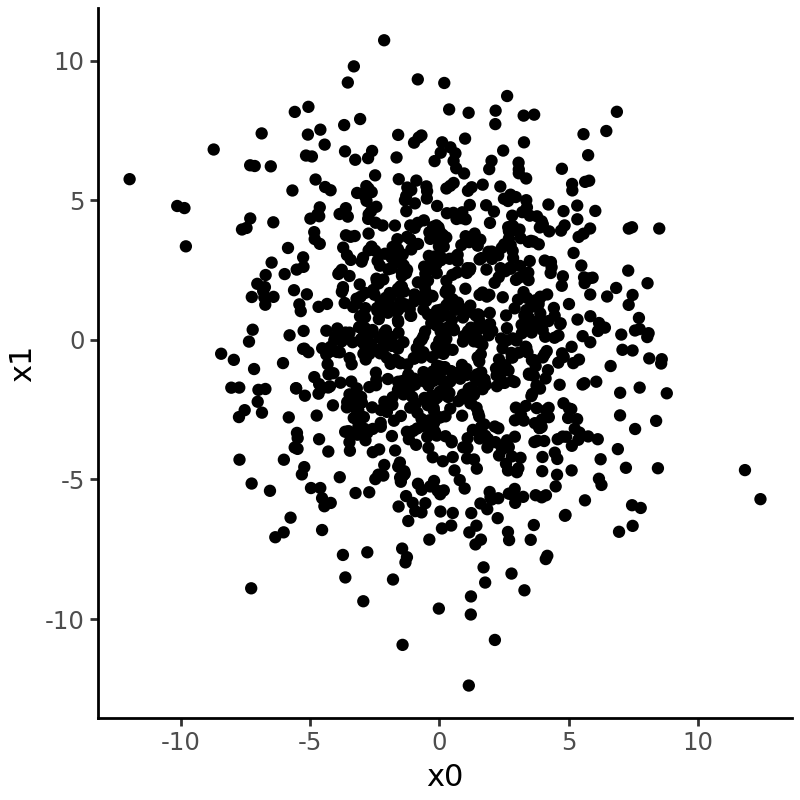

In [74]:
my_z = Z_lab[:1000, ]
ggplot(
    pd.DataFrame(my_z, columns=[f"x{i}" for i in range(my_z.shape[1])]),
    aes(x="x0", y="x1")
) + \
    geom_point() + \
    theme_classic() + theme(figure_size=(4, 4))

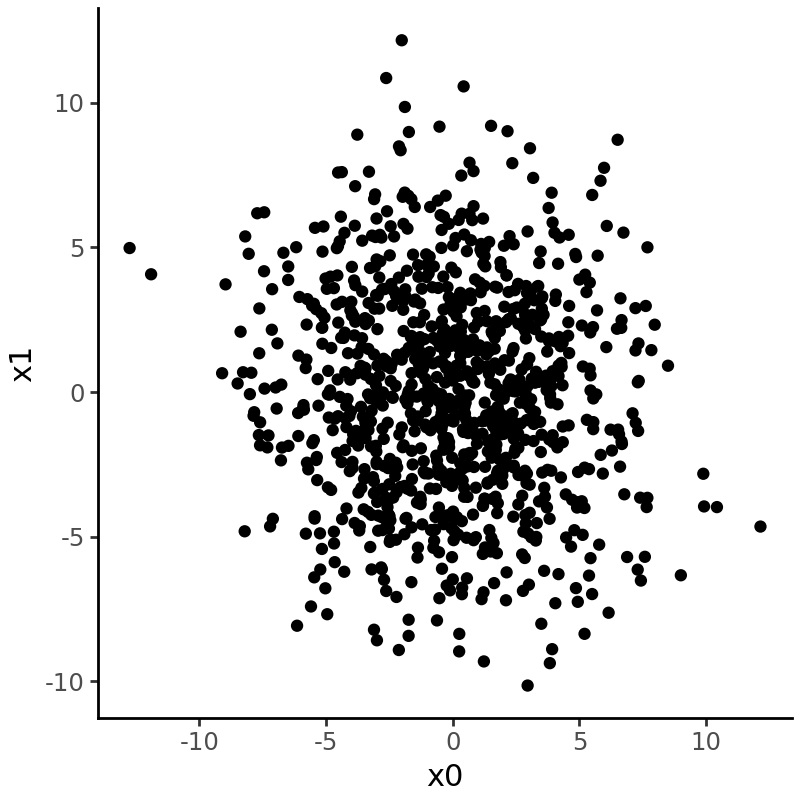

In [75]:
my_z = Z_ppi[:1000, ]
ggplot(
    pd.DataFrame(my_z, columns=[f"x{i}" for i in range(my_z.shape[1])]),
    aes(x="x0", y="x1")
) + \
    geom_point() + \
    theme_classic() + theme(figure_size=(4, 4))

In [ ]:
W_full = get_w(Sigma_full, n_comps=n_comps)
Z_full = X_full @ W_full
Z_ppi_full = X_full @ W_ppi
Z_pred_full = X_full @ W_pred
Z_lab_full = X_full @ W_lab

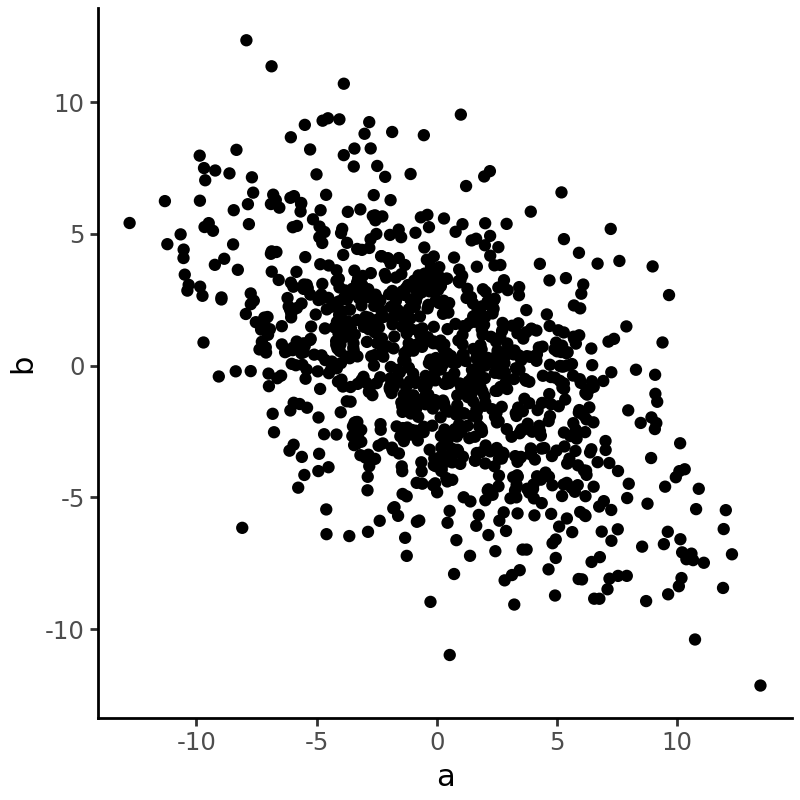

In [79]:
ggplot(
    pd.DataFrame(np.c_[Z_full[:1000, 0], Z_ppi_full[:1000, 0]], columns=["a", "b"]),
    aes(x="a", y="b")
) + \
    geom_point() + \
    theme_classic() + theme(figure_size=(4, 4))

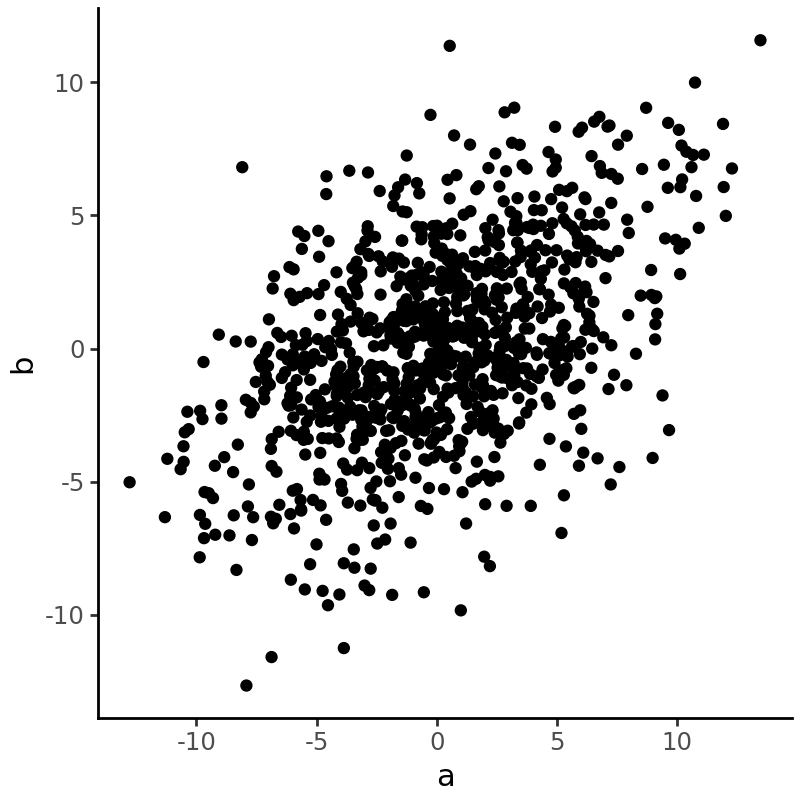

In [80]:
ggplot(
    pd.DataFrame(np.c_[Z_full[:1000, 0], Z_lab_full[:1000, 0]], columns=["a", "b"]),
    aes(x="a", y="b")
) + \
    geom_point() + \
    theme_classic() + theme(figure_size=(4, 4))

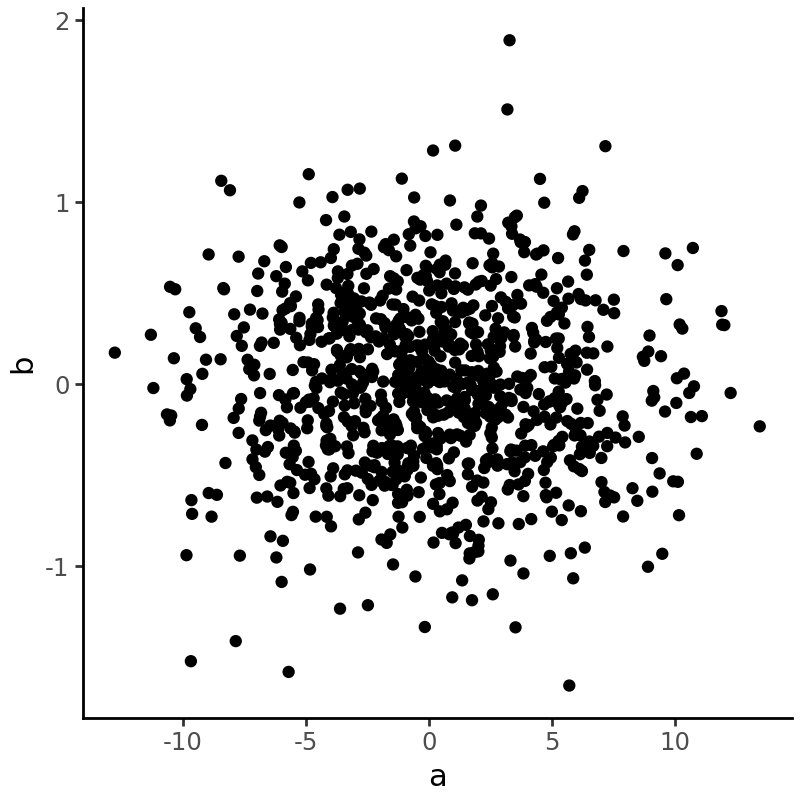

In [81]:
ggplot(
    pd.DataFrame(np.c_[Z_full[:1000, 0], Z_pred_full[:1000, 0]], columns=["a", "b"]),
    aes(x="a", y="b")
) + \
    geom_point() + \
    theme_classic() + theme(figure_size=(4, 4))

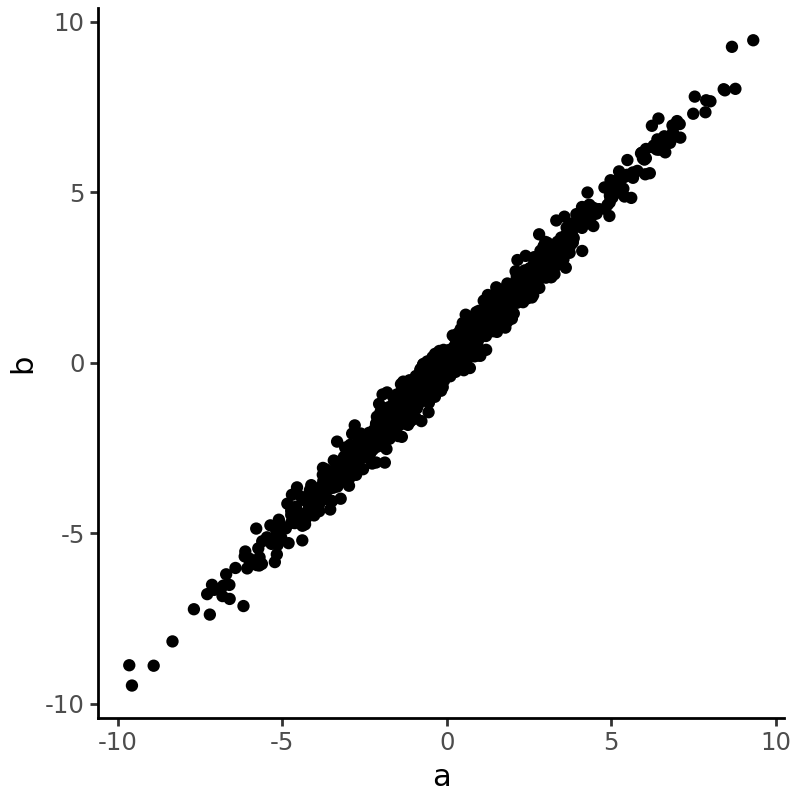

In [136]:
ggplot(
    pd.DataFrame(np.c_[Z_ppi_full[:1000, 0], Z_lab_full[:1000, 0]], columns=["a", "b"]),
    aes(x="a", y="b")
) + \
    geom_point() + \
    theme_classic() + theme(figure_size=(4, 4))